# Resolution function

Plots global maps of the resolution function and the fraction of ocean area under resolution function over time for a set of four CESM2-MOM6 simulations.

In [2]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [3]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']
c= ['xkcd:black','xkcd:grey','xkcd:dark red','xkcd:dark orange'] 


loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])

alpha_res = 2.
p_res = 50
def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


In [4]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012')
    cluster.scale(nw)
    client = Client(cluster)

client

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/45693/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/45693/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.177:46881,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/45693/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time

res_funcs = []
Rd_dxs = []

for i in range(num_sims):
    sim = sims[i]
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    sim.ds = sim.ds.chunk({'time': 12})
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))

    Rd_dx = sim.ds.Rd_dx.mean('time').compute()
    Rd_dxs.append(Rd_dx)
    
    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)


Task exception was never retrieved
future: <Task finished name='Task-392' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-376' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-345' coro=<

In [5]:
save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

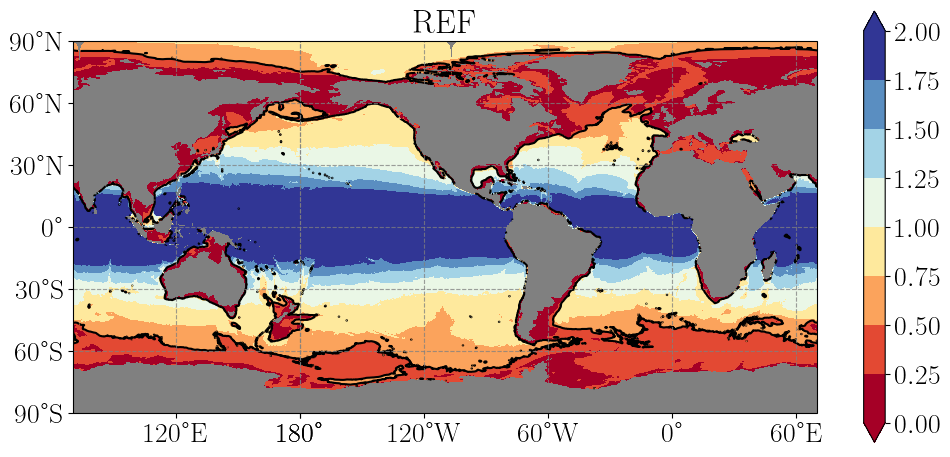

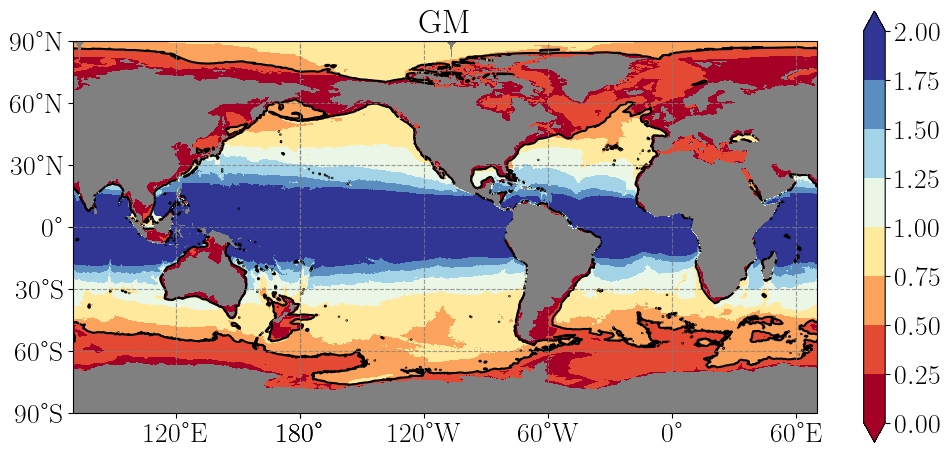

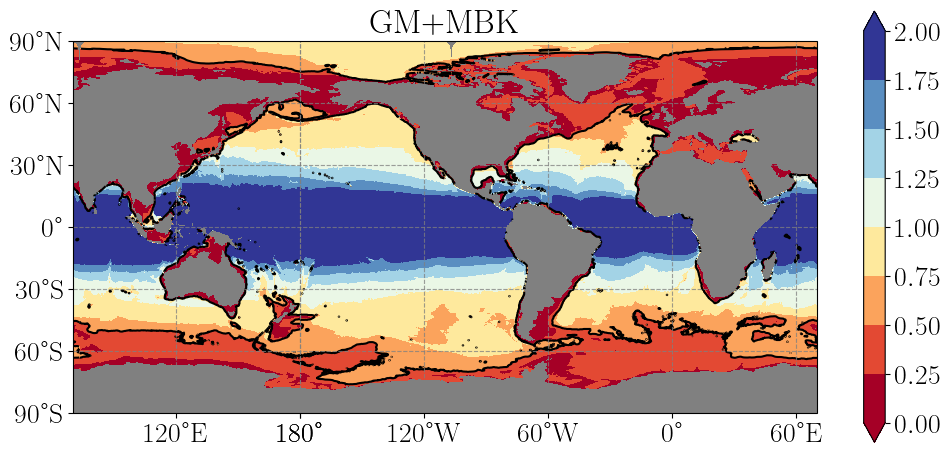

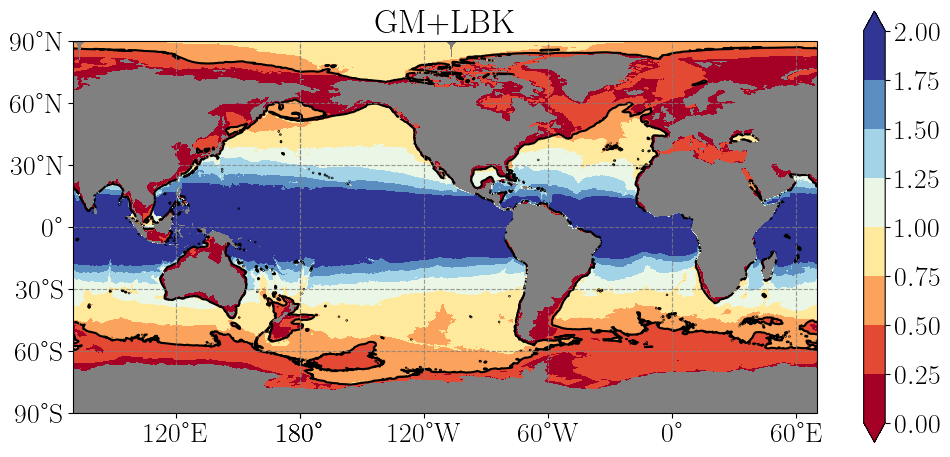

In [6]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu
vmin, vmax = 0, 2
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, Rd in zip(sims, res_funcs, Rd_dxs):
    title = sim.short_name
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(Rd,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+title+'_resolution.png',dpi=300)

# Temporal variability of the resolution function

In [7]:
%%time
ref_land_mask = sims[0].ds['area_t'].isel(time=0).notnull()

r_stds = []
for sim in sims:
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    ds = sim.ds.sel(time=slice(start_date, end_date))
    
    r_txy = resolution(ds.Rd_dx, alpha_res, p_res)
    r_std = r_txy.std(dim='time', skipna=True)
    
    # Use the reference simulation's mask
    r_std = r_std.where(ref_land_mask)
    
    r_stds.append(r_std)

Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
CPU times: user 1min 24s, sys: 7.23 s, total: 1min 31s
Wall time: 3min 9s


In [8]:
%%time

#905602
ref_mask = r_stds[0].notnull()
r_std = r_std.where(ref_mask)
print(
      ' r_std  min/max =', float(r_std.min()), '/', float(r_std.max()),
      ' n_ocean_cells =', int(r_std.count()))

 r_std  min/max = 0.0 / 0.49936097860336304  n_ocean_cells = 905602
CPU times: user 10 s, sys: 584 ms, total: 10.6 s
Wall time: 1min 4s


CPU times: user 52.1 s, sys: 1.86 s, total: 54 s
Wall time: 2min 52s


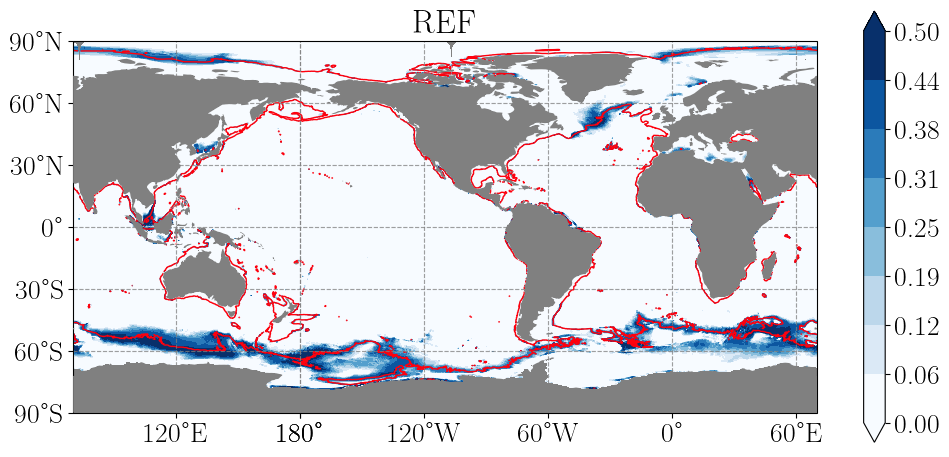

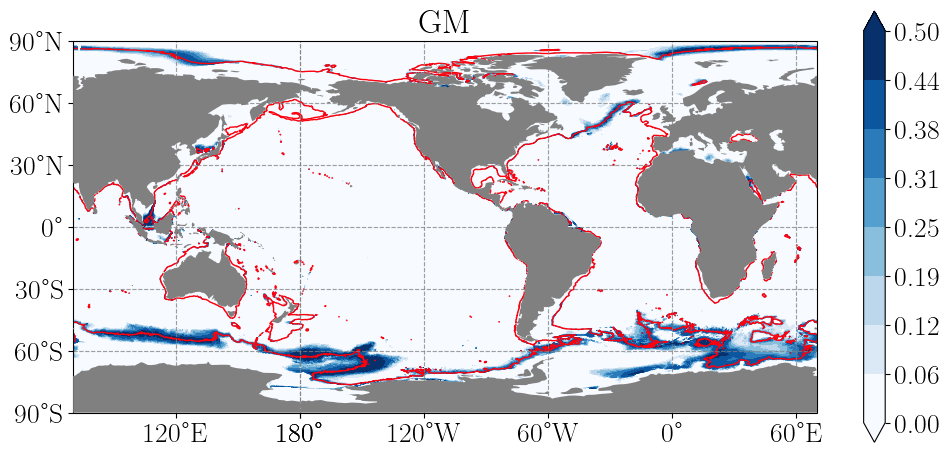

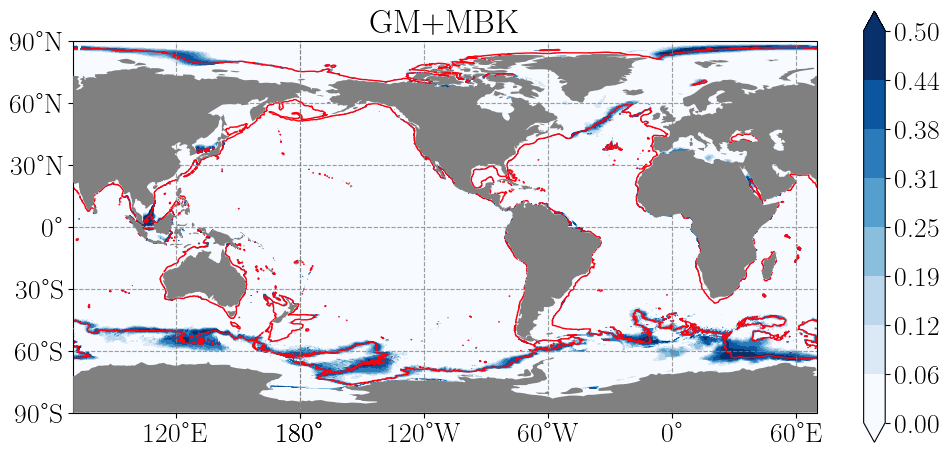

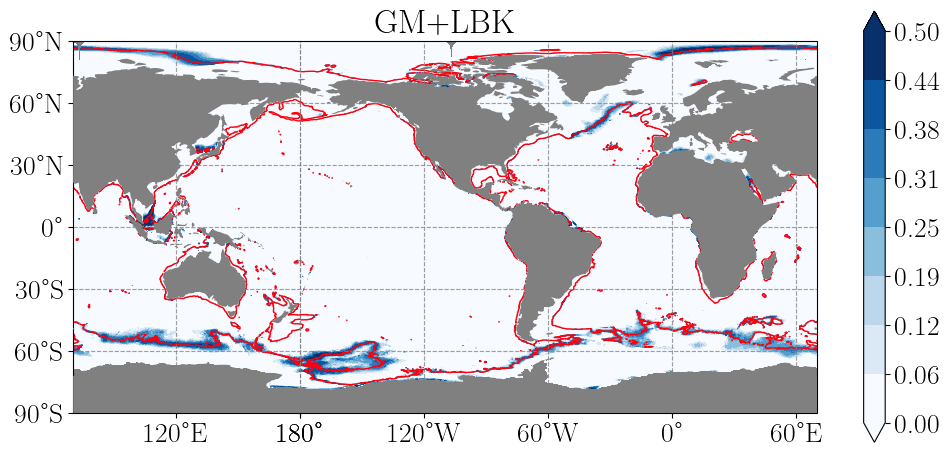

In [9]:
%%time
import matplotlib.colors as mcolors
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker  # for colorbar formatting

cmap = cm.Blues
vmin, vmax = 0, 0.5
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
ref_mask = r_stds[0].notnull()
for sim, R, r_std in zip(sims, res_funcs, r_stds):
    r_std = r_std.where(ref_mask)
    title = sim.short_name
    mappable = sim.plot_global_discrete(r_std,    # keeps ocean, sets land to NaN,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='xkcd:bright red', 
                                        contour_linewidth=1., 
                                        contour_linestyle='-')
    
    # Grab the colorbar and format ticks
    cbar = mappable.colorbar
    cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
    ax = plt.gca()
    ax.add_feature(cartopy.feature.LAND, facecolor='gray',zorder=10)    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+title+'_resolution_std.png',dpi=300)

# Area averaged

In [8]:
def compute_global_stats(ds, R_threshold=0.5):
    r_vals = resolution(ds.Rd_dx, alpha_res, p_res).fillna(0.)
    area = ds['area_t'].fillna(0.)

    # Mean of r weighted by area
    mean_r = (r_vals * area).sum(dim=['xh', 'yh']) / area.sum(dim=['xh', 'yh'])

    # Area fraction where r = 1 (i.e., R > R_0)
    r_mask = xr.where(r_vals == 1.0, 1.0, 0.0)
    frac_area = (r_mask * area).sum(dim=['xh', 'yh']) / area.sum(dim=['xh', 'yh'])

    return mean_r, frac_area

In [9]:
%%time
mean_r_list = []
frac_area_list = []

for sim in sims:
    sim.open_all_files(sim.native_path)
    sim.open_grid()
    sim.ds = sim.ds.chunk({'time': 12})
    mean_r, frac_area = compute_global_stats(sim.ds)
    mean_r_list.append(mean_r.compute())
    frac_area_list.append(frac_area.compute())

Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
Opened all files
Opened grid and assigned coordinates.
CPU times: user 3min 26s, sys: 15.6 s, total: 3min 42s
Wall time: 8min 44s


In [6]:
import pickle
save = 0
if save:
    results = {
        'mean_r_list': mean_r_list,
        'frac_area_list': frac_area_list,
    }
    
    with open('resolution_function_frac_area_list.pkl', 'wb') as f:
        pickle.dump(results, f, protocol=4)
else:
    with open('resolution_function_frac_area_list.pkl', 'rb') as f:
        results = pickle.load(f)
    
    mean_r_list   = results['mean_r_list']
    frac_area_list = results['frac_area_list']

CPU times: user 419 ms, sys: 15.6 ms, total: 434 ms
Wall time: 693 ms


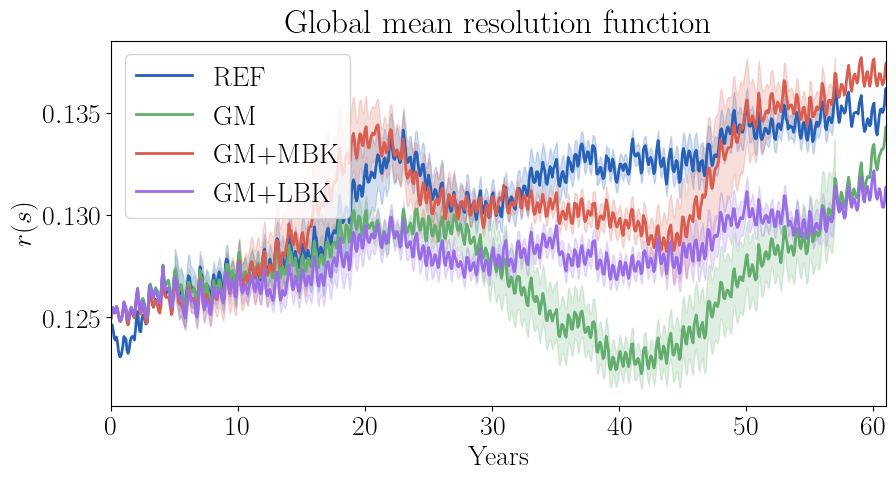

In [10]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
#c= ['xkcd:black','xkcd:grey','xkcd:light red','xkcd:light blue'] 
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale
window = 12*10

for i in range(num_sims):
    sim = sims[i]
    field = mean_r_list[i]
    #std = field.std().item()
    std = field.rolling(time=window, center=True).std()

    # Convert time coordinate to days
    days = (sim.ds.time - sim.ds.time[0]).astype('timedelta64').astype(float)
    days /= (1e9*3600*24*365.25)
    ## Start the control run at year 50. (bs run start at year 60!)
    ax.plot(days, field, label=snames[i],c=c[i],lw=2)
    ax.fill_between(days, field - std, field + std, color=c[i], alpha=0.2)


ax.set_xlabel('Years')
ax.set_ylabel(r'$r(s)$')
title = 'Global mean resolution function'
ax.set_title(title)
#ax.set_ylim([0.0e18, 5.0e18])
ax.set_xlim([0, 61])

ax.tick_params(axis='both', which='major')
#ax.tick_params(axis='both', which='minor', labelsize=8)

ax.legend(loc='best')
plt.subplots_adjust(bottom=0.15)

#ax.grid()
plt.savefig(save_path+title+'_resolution_global_mean.png',dpi=300)

CPU times: user 361 ms, sys: 11.7 ms, total: 373 ms
Wall time: 556 ms


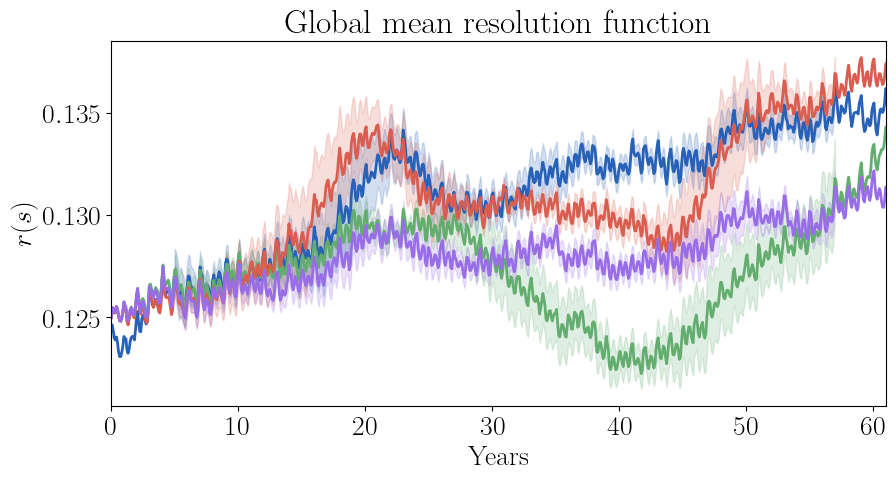

In [11]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
window = 12*10

for i in range(num_sims):
    sim = sims[i]
    field = mean_r_list[i]
    #std = field.std().item()
    std = field.rolling(time=window, center=True).std()

    # Convert time coordinate to days
    days = (sim.ds.time - sim.ds.time[0]).astype('timedelta64').astype(float)
    days /= (1e9*3600*24*365.25)
    ## Start the control run at year 50. (bs run start at year 60!)
    ax.plot(days, field, label=snames[i],c=c[i],lw=2)
    ax.fill_between(days, field - std, field + std, color=c[i], alpha=0.2)


ax.set_xlabel('Years')
ax.set_ylabel(r'$r(s)$')
title = 'Global mean resolution function'
ax.set_title(title)
#ax.set_ylim([0.0e18, 5.0e18])
ax.set_xlim([0, 61])

ax.tick_params(axis='both', which='major')
#ax.tick_params(axis='both', which='minor', labelsize=8)

#ax.legend(loc='best')
plt.subplots_adjust(bottom=0.15)
#ax.grid()
plt.savefig(save_path+title+'_resolution_global_mean_no_legend.png',dpi=300)